<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/8-dimensionality-reduction/01_dimensionality_reduction_based_on_projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dimensionality reduction based on projection

**Principal Component Analysis** (PCA) is by far the most popular dimensionality reduction
algorithm. First it identifies the hyperplane that lies closest to the data, and then
it projects the data onto it.

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/8-dimensionality-reduction/images/0.png?raw=1' width='600'/>

**Preserving the Variance**

Before you can project the training set onto a lower-dimensional hyperplane, you
first need to choose the right hyperplane.

For example, a simple 2D dataset is represented
on the left in figure, along with three different axes (i.e., 1D hyperplanes).
On the right is the result of the projection of the dataset onto each of these axes.

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/8-dimensionality-reduction/images/1.png?raw=1' width='600'/>

As you can see, the projection onto the solid line preserves the maximum variance, while
the projection onto the dotted line preserves very little variance and the projection
onto the dashed line preserves an intermediate amount of variance.

It seems reasonable to select the axis that preserves the maximum amount of variance,
as it will most likely lose less information than the other projections. Another
way to justify this choice is that it is the axis that minimizes the mean squared distance
between the original dataset and its projection onto that axis. This is the rather
simple idea behind [**PCA**](https://www.tandfonline.com/doi/pdf/10.1080/14786440109462720).













##Setup

In [50]:
# Common imports
import numpy as np
import os

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.datasets import make_swiss_roll
from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Let's build 3D dataset.

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

Let's load MNIST dataset.

In [4]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X_train, y = mnist["data"], mnist["target"]
X_train.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y)

##Principal Components

PCA identifies the axis that accounts for the largest amount of variance in the training set.

It also finds a second axis, orthogonal to the
first one, that accounts for the largest amount of remaining variance. 


In this 2D
example there is no choice: it is the dotted line. If it were a higher-dimensional dataset,
PCA would also find a third axis, orthogonal to both previous axes, and a fourth,
a fifth, and so on—as many axes as the number of dimensions in the dataset.

The $i^{th}$ axis is called the $i^{th}$ principal component (PC) of the data.

- The first PC is the axis on which vector $c_1$ lies
- The second PC is the axis on which vector $c_2$ lies

The first two PCs are the orthogonal axes on which the
two arrows lie, on the plane, and the third PC is the axis orthogonal to that plane.

So how can you find the principal components of a training set?

Luckily, there is a standard matrix factorization technique called **Singular Value Decomposition** (SVD)
that can decompose the training set matrix $X$ into the matrix multiplication of three
matrices $U Σ V^⊺$, where $V$ contains the unit vectors that define all the principal components
that we are looking for.

$
\mathbf{V}^T =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

The following Python code uses NumPy’s `svd()` function to obtain all the principal
components of the training set, then extracts the two unit vectors that define the first
two PCs:

In [7]:
# don’t forget to center the data first
X_centered = X - X.mean(axis=0)

U, s , Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

PCA assumes that the dataset is centered around the origin.

If you implement PCA yourself, or if you use other libraries, don’t forget to center the data first.

In [8]:
c1

array([0.93636116, 0.29854881, 0.18465208])

In [9]:
c2

array([-0.34027485,  0.90119108,  0.2684542 ])

In [10]:
c3 = Vt.T[:, 2]
c3

array([-0.08626012, -0.31420255,  0.94542898])

##Projecting Down to d Dimensions

Once you have identified all the principal components, you can reduce the dimensionality
of the dataset down to `d` dimensions by projecting it onto the hyperplane
defined by the first `d` principal components. Selecting this hyperplane ensures that the
projection will preserve as much variance as possible.

To project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ of
dimensionality `d`, compute the matrix multiplication of the training set matrix $X$ by
the matrix $W_d$, defined as the matrix containing the first `d` columns of $V$.

$
\mathbf{X}_{d\text{-proj}} = \mathbf{X} \mathbf{W}_d
$

The following Python code projects the training set onto the plane defined by the first
two principal components:

In [11]:
# define the matrix containing the first 2 columns of  V
W2 = Vt.T[:, :2]
# now project it onto the hyperplane and obtain a reduced dataset of dimensionality 2
X2D = X_centered.dot(W2)

In [12]:
X2D.shape  # reduced 

(60, 2)

In [13]:
X.shape  # original

(60, 3)

You now know how to reduce the dimensionality of any dataset
down to any number of dimensions, while preserving as much variance as possible.

## PCA using Scikit-Learn

Scikit-Learn’s PCA class uses SVD decomposition to implement PCA.

Let's applies PCA to reduce the dimensionality
of the dataset down to two dimensions (note that it automatically takes care of centering
the data):

In [14]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
X2D.shape

(60, 2)

After fitting the PCA transformer to the dataset, its `components_` attribute holds the
transpose of $W_d$ (e.g., the unit vector that defines the first principal component is
equal to `pca.components_.T[:, 0])`.

In [15]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [16]:
pca.components_.T[:, 0]  # c1 = first principal component

array([-0.93636116, -0.29854881, -0.18465208])

In [17]:
pca.components_.T[:, 1]  # c2 = second principal component

array([ 0.34027485, -0.90119108, -0.2684542 ])

###Explained Variance Ratio

Another useful piece of information is the explained variance ratio of each principal
component, available via the `explained_variance_ratio_` variable. The ratio indicates
the proportion of the dataset’s variance that lies along each principal component.

For example, let’s look at the explained variance ratios of the first two
components of the 3D dataset.

In [18]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

This output tells you that 84.2% of the dataset’s variance lies along the first PC, and
14.6% lies along the second PC. This leaves less than 1.2% for the third PC, so it is
reasonable to assume that the third PC probably carries little information.

In [19]:
pca.explained_variance_

array([0.77830975, 0.1351726 ])

###Choosing the Right Number of Dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is
simpler to choose the number of dimensions that add up to a sufficiently large portion
of the variance (e.g., 95%). 

Unless, of course, you are reducing dimensionality for
data visualization—in that case you will want to reduce the dimensionality down to 2
or 3.

Let's performs PCA without reducing dimensionality, then computes
the minimum number of dimensions required to preserve 95% of the training set’s
variance:

In [20]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

2

You could then set `n_components=d` and run PCA again. But there is a much better
option: instead of specifying the number of principal components you want to preserve,
you can set `n_components` to be a float between 0.0 and 1.0, indicating the ratio
of variance you wish to preserve:

In [21]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
X_reduced.shape

(60, 2)

Yet another option is to plot the explained variance as a function of the number of
dimensions.

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/8-dimensionality-reduction/images/2.png?raw=1' width='600'/>

There will usually be an elbow in the
curve, where the explained variance stops growing fast. In this case, you can see that
reducing the dimensionality down to about 100 dimensions wouldn’t lose too much
explained variance.

##PCA for Compression

After dimensionality reduction, the training set takes up much less space. As an
example, try applying PCA to the MNIST dataset while preserving 95% of its variance.
You should find that each instance will have just over 150 features, instead of
the original 784 features. So, while most of the variance is preserved, the dataset is
now less than 20% of its original size! This is a reasonable compression ratio, and you
can see how this size reduction can speed up a classification algorithm (such as an
SVM classifier) tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by
applying the inverse transformation of the PCA projection. This won’t give you back
the original data, since the projection lost a bit of information (within the 5% variance
that was dropped), but it will likely be close to the original data. 

The mean
squared distance between the original data and the reconstructed data (compressed
and then decompressed) is called the reconstruction error.

Let's compresses the MNIST dataset down to 154 dimensions, then
uses the `inverse_transform()` method to decompress it back to 784 dimensions:

In [22]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'Compressed')

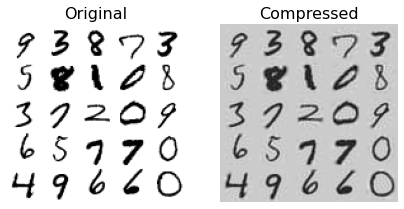

In [23]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

You can see that there is a
slight image quality loss, but the digits are still mostly intact.

The equation of the inverse transformation is shown below.

$
\mathbf{X}_{d\text{-proj}} = \mathbf{X} \mathbf{W}_d
$

$
\mathbf{X}_{\text{recovered}} = \mathbf{X}_{d\text{-proj}} {\mathbf{W}_d}^T
$

In [24]:
X_reduced_pca = X_reduced

##Incremental PCA

One problem with the preceding implementations of PCA is that they require the
whole training set to fit in memory in order for the algorithm to run. Fortunately,
Incremental PCA (IPCA) algorithms have been developed. They allow you to split the
training set into mini-batches and feed an IPCA algorithm one mini-batch at a time.

This is useful for large training sets and for applying PCA online (i.e., on the fly, as
new instances arrive).

Let's splits the MNIST dataset into 100 `mini-batches` (using NumPy’s
`array_split()` function) and feeds them to Scikit-Learn’s `IncrementalPCA` class to
reduce the dimensionality of the MNIST dataset down to 154 dimensions (just like
before). 

Note that you must call the `partial_fit()` method with each mini-batch,
rather than the `fit()` method with the whole training set:

In [25]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for x_batch in np.array_split(X_train, n_batches):
  print(".", end="")
  inc_pca.partial_fit(x_batch)
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [26]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

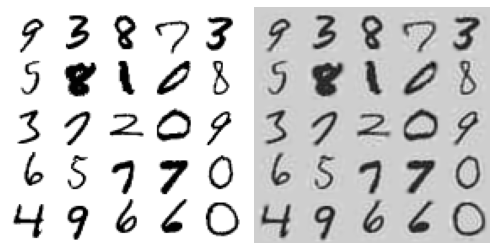

In [27]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. 

First, the means are equal:

In [28]:
X_reduced_inc_pca = X_reduced

np.allclose(pca.mean_, inc_pca.mean_)

True

But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [29]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

Alternatively, you can use NumPy’s `memmap` class, which allows you to manipulate a
large array stored in a binary file on disk as if it were entirely in memory; the class
loads only the data it needs in memory, when it needs it.

Since the `IncrementalPCA`
class uses only a small part of the array at any given time, the memory usage remains
under control. This makes it possible to call the usual `fit()` method.

Let's create the memmap() structure and copy the MNIST data into it.

 This would typically be done by a first program:

In [30]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype="float32", mode="write", shape=(m, n))
X_mm[:] = X_train

Now deleting the memmap() object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [31]:
del X_mm

Next, another program would load the data and use it for training:

In [32]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

In [33]:
X_reduced = inc_pca.transform(X_train)

In [34]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

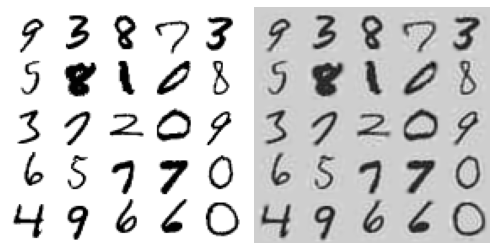

In [35]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

##Kernel PCA

the kernel trick, a mathematical technique that implicitly
maps instances into a very high-dimensional space (called the feature space), enabling
nonlinear classification and regression with Support Vector Machines. Recall that a
linear decision boundary in the high-dimensional feature space corresponds to a
complex nonlinear decision boundary in the original space.

It turns out that the same trick can be applied to PCA, making it possible to perform
complex nonlinear projections for dimensionality reduction. This is called [Kernel PCA (kPCA)](https://link.springer.com/chapter/10.1007/BFb0020217).It is often good at preserving clusters of instances after projection, or
sometimes even unrolling datasets that lie close to a twisted manifold.

Let's uses Scikit-Learn’s KernelPCA class to perform kPCA with an RBF
kernel:

In [36]:
# loading swiss roll dataset
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [37]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
x_reduced= rbf_pca.fit_transform(X)

Now we will usin Swiss-Roll dataset and reduce to two dimensions using a linear kernel
(equivalent to simply using the PCA class), an RBF kernel, and a sigmoid kernel.

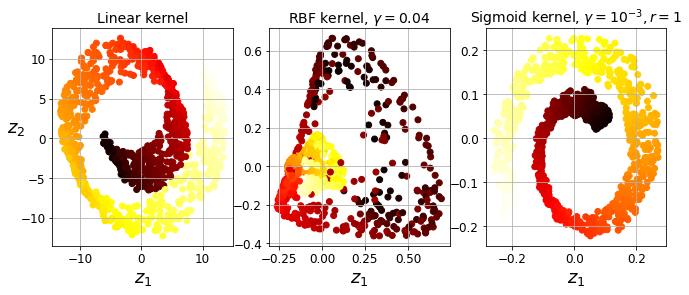

In [38]:
lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

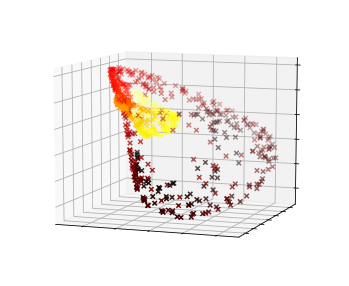

In [39]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

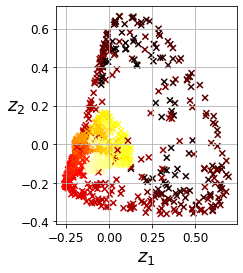

In [40]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

###Selecting a Kernel and Tuning Hyperparameters

As kPCA is an unsupervised learning algorithm, there is no obvious performance
measure to help you select the best kernel and hyperparameter values.

That said,
dimensionality reduction is often a preparation step for a supervised learning task
(e.g., classification), so you can use grid search to select the kernel and hyperparameters
that lead to the best performance on that task.

Let's creates a twostep
pipeline, first reducing dimensionality to two dimensions using kPCA, then
applying Logistic Regression for classification. 

Then it uses GridSearchCV to find the
best kernel and gamma value for kPCA in order to get the best classification accuracy
at the end of the pipeline:

In [41]:
clf_pipeline = Pipeline([
   ("kpca", KernelPCA(n_components=2)),
   ("log_reg", LogisticRegression(solver="liblinear"))                      
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf_pipeline, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

The best kernel and hyperparameters are then available through the `best_params_` variable:

In [42]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


Another approach, this time entirely unsupervised, is to select the kernel and hyperparameters
that yield the lowest reconstruction error. Note that reconstruction is not
as easy as with linear PCA.

One solution is to train a
supervised regression model, with the projected instances as the training set and the
original instances as the targets. Scikit-Learn will do this automatically if you set
`fit_inverse_transform=True`:

In [43]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
x_reduced = rbf_pca.fit_transform(X)
x_preimage = rbf_pca.inverse_transform(x_reduced)

You can then compute the reconstruction pre-image error:

In [44]:
mean_squared_error(X, x_preimage)

32.78630879576612

Now you can use grid search with cross-validation to find the kernel and hyperparameters
that minimize this error.

##Locally Linear Embedding

[Locally Linear Embedding (LLE)](https://www.science.org/doi/10.1126/science.290.5500.2323) is another powerful nonlinear dimensionality reduction
(NLDR) technique. It is a Manifold Learning technique that does not rely on
projections.

In a nutshell, LLE works by first measuring
how each training instance linearly relates to its closest neighbors (c.n.), and then
looking for a low-dimensional representation of the training set where these local
relationships are best preserved (more details shortly). This approach makes it particularly
good at unrolling twisted manifolds, especially when there is not too much
noise.

Let's uses Scikit-Learn’s `LocallyLinearEmbedding` class to unroll the
Swiss roll:

In [47]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [48]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

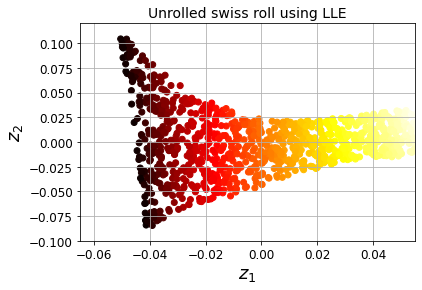

In [49]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

As you can see, the Swiss roll is
completely unrolled, and the distances between instances are locally well preserved.

However, distances are not preserved on a larger scale: the left part of the unrolled
Swiss roll is stretched, while the right part is squeezed. 

Nevertheless, LLE did a pretty
good job at modeling the manifold.

##Other Dimensionality Reduction Techniques

There are many other dimensionality reduction techniques, several of which are
available in Scikit-Learn. 

Here are some of the most popular ones:

* Multidimensional Scaling (MDS)
* Isomap
* t-Distributed Stochastic Neighbor Embedding (t-SNE)
* Linear Discriminant Analysis (LDA)

###Multidimensional Scaling (MDS)

It reduces dimensionality while trying to preserve the distances between the
instances.

In [51]:
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

###Isomap

It creates a graph by connecting each instance to its nearest neighbors, then
reduces dimensionality while trying to preserve the geodesic distances9 between
the instances.

In [52]:
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

###t-Distributed Stochastic Neighbor Embedding (t-SNE)

It reduces dimensionality while trying to keep similar instances close and dissimilar
instances apart. 

It is mostly used for visualization, in particular to visualize
clusters of instances in high-dimensional space (e.g., to visualize the MNIST
images in 2D).

In [53]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


###Linear Discriminant Analysis (LDA)

It is a classification algorithm, but during training it learns the most discriminative
axes between the classes, and these axes can then be used to define a hyperplane
onto which to project the data.

The benefit of this approach is that the projection
will keep classes as far apart as possible, so LDA is a good technique to reduce
dimensionality before running another classification algorithm such as an SVM
classifier.

In [55]:
lda = LinearDiscriminantAnalysis(n_components=2)

x_mnist = mnist["data"]
y_mnist = mnist["target"]

lda.fit(x_mnist, y_mnist)
X_reduced_lda = lda.transform(x_mnist)

Let's see the results of a few of these techniques.

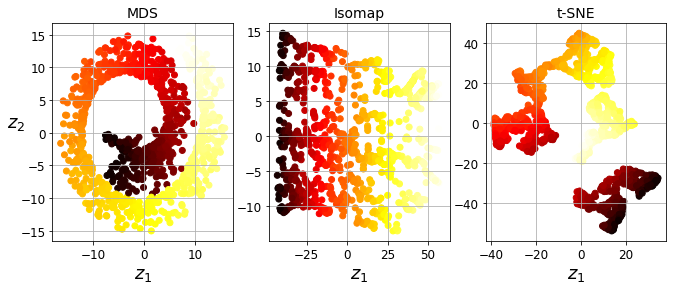

In [56]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()